In [83]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.api as sm 
from scipy.stats import norm
from scipy.stats import shapiro
from statsmodels.stats.correlation_tools import corr_nearest

In [84]:
# reading the raw data file containing CDS spreads for the 5 credit entities
data = pd.read_csv ("C:/Users/anirbighosh/Documents/CQF/Final Project/data files/corr.csv")
cols = ['BAC_return', 'CITI_return', 'GS_return', 'JPMC_return', 'MS_return' ]
data = data[cols]
#data.head()

### Section I: Analysis of the raw data, calculating the correlation matrices (Pearson & Kendall), and generating the respective Cholesky matrices

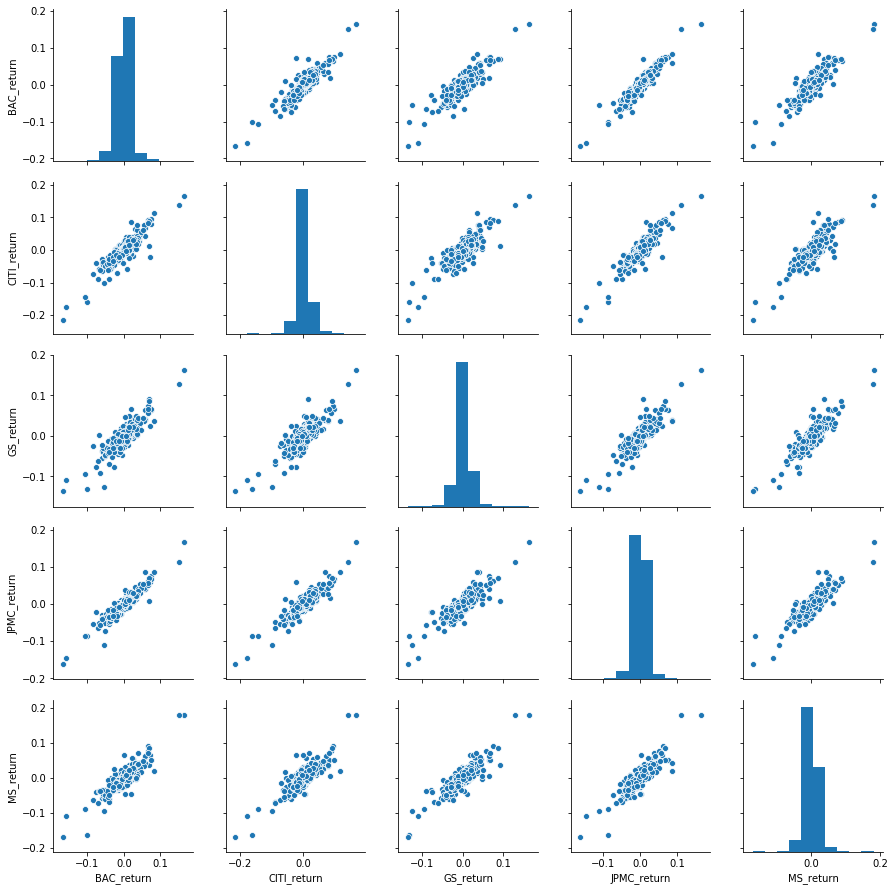

In [85]:
#Analysis of raw data - step I -histograms and scatter plots

import seaborn as sns
sns.pairplot(data)

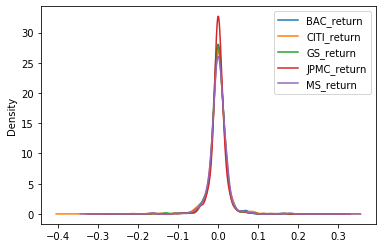

In [60]:
#Analysis of raw data - step II - KDE plots

data.plot.kde()

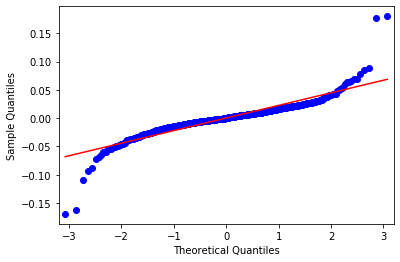

In [94]:
#Analysis of raw data - step III - Q-Q plots to assess normality

sm.qqplot(data['MS_return'], line='s')
plt.show()

In [62]:
#Analysis of raw data - step IV - Shapiro-Wilks test to assess normality

stat, p = shapiro(data['BAC_return'])
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Sample does not look Gaussian (reject H0)


In [63]:
# function to convert the data to normal

def convert_to_normal(X):
    ecdf = ECDF(X, side = 'right')
    U = ecdf(X)
    Z = norm.ppf(U)
    return Z

In [64]:
# converting the data to normal

n_list = []
n_list.append(convert_to_normal(data['BAC_return']))
n_list.append(convert_to_normal(data['CITI_return']))
n_list.append(convert_to_normal(data['GS_return']))
n_list.append(convert_to_normal(data['JPMC_return']))
n_list.append(convert_to_normal(data['MS_return']))
data_normal = pd.DataFrame(n_list).transpose()
data_normal.replace([np.inf, -np.inf], np.nan, inplace=True)
data_normal.dropna(inplace = True)

In [65]:
# Checking if the transformed data passes the normality check

stat, p = shapiro(data_normal[4])
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Sample looks Gaussian (fail to reject H0)


In [74]:
# Pearson's correlation - using the transformed data

corr_pearson = data_normal.corr(method='pearson')
print(corr_pearson)

          0         1         2         3         4
0  1.000000  0.874067  0.830036  0.917487  0.849246
1  0.874067  1.000000  0.814210  0.878369  0.828025
2  0.830036  0.814210  1.000000  0.835791  0.860827
3  0.917487  0.878369  0.835791  1.000000  0.863615
4  0.849246  0.828025  0.860827  0.863615  1.000000


In [103]:
# Kendalls' tau - using the raw data (required for the "t" copula)

corr_kendall = data.corr(method='kendall')
print(corr_kendall)
corr_kendall = corr_kendall.apply(lambda x: np.sin(0.5 * math.pi *x))
#print(corr_kendall)

             BAC_return  CITI_return  GS_return  JPMC_return  MS_return
BAC_return     1.000000     0.691668   0.623598     0.737930   0.657894
CITI_return    0.691668     1.000000   0.615860     0.692648   0.643437
GS_return      0.623598     0.615860   1.000000     0.629897   0.672916
JPMC_return    0.737930     0.692648   0.629897     1.000000   0.673316
MS_return      0.657894     0.643437   0.672916     0.673316   1.000000


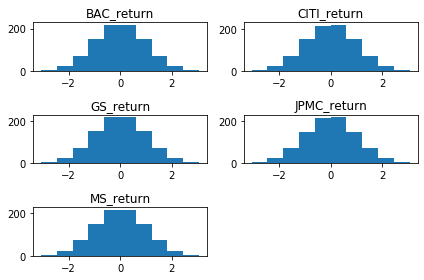

In [96]:
data_normal.columns =['BAC_return', 'CITI_return', 'GS_return', 'JPMC_return', 'MS_return'] 
data_normal.hist(grid = False)
plt.tight_layout()
plt.show()

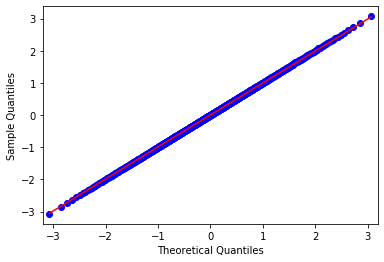

In [102]:
# Q-Q plots of transformed data

sm.qqplot(data_normal['MS_return'], line='s')
plt.show()

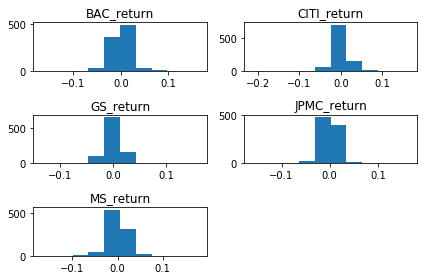

In [88]:
data.hist(grid = False)
plt.tight_layout()
plt.show()

In [82]:
calculate_cholesky_matrix(corr_pearson)

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.87406663, 0.48580606, 0.        , 0.        , 0.        ],
       [0.83003574, 0.18259106, 0.5269736 , 0.        , 0.        ],
       [0.91748698, 0.1573138 , 0.08637977, 0.35497683, 0.        ],
       [0.84924604, 0.17646443, 0.23473966, 0.10255764, 0.42663882]])

In [52]:
calculate_cholesky_matrix(corr_kendall)

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.88498847, 0.46561294, 0.        , 0.        , 0.        ],
       [0.83024374, 0.19039793, 0.523874  , 0.        , 0.        ],
       [0.91645853, 0.1603239 , 0.08457925, 0.35671609, 0.        ],
       [0.85905353, 0.18675516, 0.23309065, 0.09603693, 0.40446904]])

### Section II - Function definitions

In [ ]:
# cholesky decomposition 

def calculate_cholesky_matrix(corr):

    # decomposing the matrix using cholesky
    if is_pos_def(corr):
        corr_decomp = np.linalg.cholesky(corr) 
        return corr_decomp 
    else:
        corr_near = corr_nearest(corr, threshold=1e-15, n_fact=100)
        corr_decomp = np.linalg.cholesky(corr_near) 
        return corr_decomp

In [ ]:
# function to test if a correlation matrix is positive definite

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [81]:
print(np.sum(np.array(corr_pearson)))
print(np.sum(np.array(calculate_cholesky_matrix(corr_pearson))))
print(np.sum(np.array(corr_kendall)))
print(np.sum(np.array(calculate_cholesky_matrix(corr_kendall))))


22.103344787062547
7.205277068811856
22.249750039612408
7.192600142173497
